### Callin Switzer
###

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import os
import csv
import time
from scipy import signal
import itertools as it
import sys
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import scipy.io
import glob
import itertools

In [2]:
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
print("TensorFlow successfully installed.")
if tf.test.is_built_with_cuda():
    print("The installed version of TensorFlow includes GPU support.")

Using TensorFlow backend.


TensorFlow successfully installed.
The installed version of TensorFlow includes GPU support.


In [3]:
print(sys.version, "\n")
print("last run on " + str(datetime.now()))

3.6.6 | packaged by conda-forge | (default, Jul 26 2018, 11:48:23) [MSC v.1900 64 bit (AMD64)] 

last run on 2018-08-16 14:46:03.922544


In [4]:
# data directory
dataDir = r"D:\Dropbox\dataAnalysisForOthers\MothMuscleLength\Data"

# figure directory
figDir = r"D:\Dropbox\dataAnalysisForOthers\MothMuscleLength\Figures" 
if not os.path.exists(figDir):
    os.makedirs(figDir)
    
# data output
dataOut = r"D:\Dropbox\dataAnalysisForOthers\MothMuscleLength\DataOut" 
if not os.path.exists(dataOut):
    os.makedirs(dataOut)

In [5]:
# read in data

def listdir_fullpath(d):
    return [os.path.join(d, f) for f in os.listdir(d)]

DLTFolders = listdir_fullpath(os.path.join(dataDir, "DLT viewer output"))
DLTFiles = [[ii for ii in glob.glob(os.path.join(DLTFolders[ii], "**_xypts**")) 
 if not os.path.basename(os.path.normpath(ii)).startswith("_")] for ii in range(len(DLTFolders))]
DLTFiles = list(itertools.chain(*DLTFiles))

MuscleFiles = [i for i in listdir_fullpath(os.path.join(dataDir, "muscle_matlab_abby"))  
               if  i.endswith(".csv") & (not os.path.basename(os.path.normpath(i)).startswith("_"))]

In [6]:
# read in DLT files
framerate = 1000.0
frame = pd.DataFrame()
list_ = []
for file_ in DLTFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    df["ID"] = os.path.basename(os.path.normpath(os.path.dirname(file_)))
    df["timestamp"] = np.arange(0, len(df)/framerate, step = 1/framerate )
    list_.append(df)
frame = pd.concat(list_, sort = False)
frame = frame.dropna(axis=1, how='all')
frame.shape

(36040, 26)

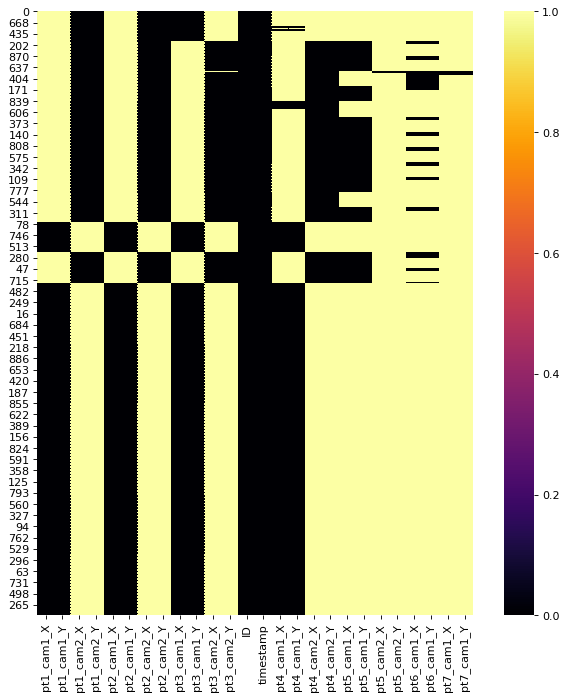

In [7]:
# visualize missing
fig = plt.figure(figsize=(10, 10), dpi=80)
ax = fig.add_subplot(111)
ax.set_aspect(aspect=0.001)
sns.heatmap(frame.iloc[:,:].isna(), cbar=True, ax=ax, cmap = "inferno")

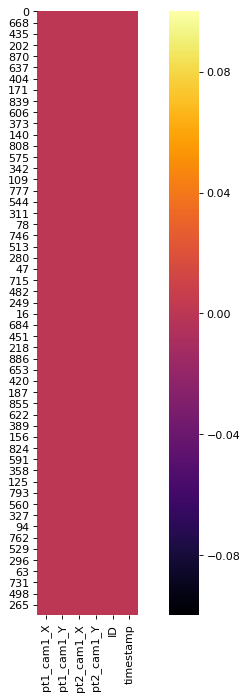

In [8]:
# combine columns
frame['pt1_cam1_X'] = frame['pt1_cam1_X'].combine_first(frame['pt1_cam2_X'])
frame['pt2_cam1_X'] = frame['pt2_cam1_X'].combine_first(frame['pt2_cam2_X'])
frame['pt1_cam1_Y'] = frame['pt1_cam1_Y'].combine_first(frame['pt1_cam2_Y'])
frame['pt2_cam1_Y'] = frame['pt2_cam1_Y'].combine_first(frame['pt2_cam2_Y'])
fig = plt.figure(figsize=(10, 10), dpi=80)
ax = fig.add_subplot(111)
ax.set_aspect(aspect=0.001)
sns.heatmap(frame.dropna(axis=1, how="any").isna(), cbar=True, ax=ax, cmap = "inferno")

In [9]:
frame = frame.dropna(axis=1, how="any")

In [10]:
frame = frame.reset_index(drop=True)

In [11]:
muscleBases = [os.path.basename(os.path.splitext(file_)[0]) for file_ in MuscleFiles]
muscleDate = [ss[:10] for ss in muscleBases]

def convInt(string):
    try:
        return(int(string))
    except:
        return(-9999)
    
muscleTrialNum = [convInt(''.join(c for c in ss.split("_")[3] if c.isdigit())) for ss in muscleBases]

In [12]:
muscleDateTrial = pd.concat([pd.Series(muscleDate), pd.Series(muscleTrialNum), pd.Series(muscleBases), pd.Series(MuscleFiles)], axis=1)
muscleDateTrial.rename(columns={0: "date", 1: "trial", 2:"muscleBase", 3:"muscleFiles"}, inplace=True)
muscleDateTrial.sort_values(by = ["date", "trial"], inplace=True)
muscleDateTrial.reset_index(inplace=True, drop = True)
print(muscleDateTrial.shape)
muscleDateTrial.head()

(247, 4)


,date,trial,muscleBase,muscleFiles
0,2018_05_21,4,2018_05_21_test4,D:\Dropbox\dataAnalysisForOthers\MothMuscleLen...
1,2018_05_21,5,2018_05_21_test5,D:\Dropbox\dataAnalysisForOthers\MothMuscleLen...
2,2018_05_21,6,2018_05_21_test6,D:\Dropbox\dataAnalysisForOthers\MothMuscleLen...
3,2018_05_21,8,2018_05_21_test8,D:\Dropbox\dataAnalysisForOthers\MothMuscleLen...
4,2018_05_21,11,2018_05_21_test11,D:\Dropbox\dataAnalysisForOthers\MothMuscleLen...


In [13]:
dltDate = [ss[:10] for ss in frame.ID]
dltTrialNum = [convInt(''.join(c for c in ss.split("_")[3] if c.isdigit())) for ss in frame.ID]
dltDateTrial = pd.concat([pd.Series(dltDate), pd.Series(dltTrialNum), frame.ID], axis=1)
dltDateTrial.rename(columns={0: "date", 1: "trial", "ID":"dltBase"}, inplace=True)
dltDateTrial.drop_duplicates(inplace=True)
dltDateTrial.sort_values(by = ["date", "trial"], inplace=True)
dltDateTrial.reset_index(inplace=True, drop = True)
print(dltDateTrial.shape)
dltDateTrial.head()

(39, 3)


,date,trial,dltBase
0,2018_06_13,1,2018_06_13_trial1
1,2018_06_13,3,2018_06_13_trial3
2,2018_06_21,5,2018_06_21_trial5
3,2018_06_22,1,2018_06_22_trial1
4,2018_06_22,3,2018_06_22_trial3


In [14]:
# find trials where we have matching dates and trials
keepTrials = pd.merge(dltDateTrial, muscleDateTrial, on=['date', 'trial'], how='inner')
print(keepTrials.shape)
keepTrials.head()

(39, 5)


,date,trial,dltBase,muscleBase,muscleFiles
0,2018_06_13,1,2018_06_13_trial1,2018_06_13_trial1,D:\Dropbox\dataAnalysisForOthers\MothMuscleLen...
1,2018_06_13,3,2018_06_13_trial3,2018_06_13_trial3,D:\Dropbox\dataAnalysisForOthers\MothMuscleLen...
2,2018_06_21,5,2018_06_21_trial5,2018_06_21_trial5,D:\Dropbox\dataAnalysisForOthers\MothMuscleLen...
3,2018_06_22,1,2018_06_22_trial1,2018_06_22_trial1,D:\Dropbox\dataAnalysisForOthers\MothMuscleLen...
4,2018_06_22,3,2018_06_22_trial3,2018_06_22_trial3,D:\Dropbox\dataAnalysisForOthers\MothMuscleLen...


In [15]:
# read in muscle files that match DLT files
framerate = 25000.0 # not sure
frame2 = pd.DataFrame()
list_ = []
for file_ in keepTrials.muscleFiles:
    df = pd.read_csv(file_,index_col=None, header=None)
    df = df[df.iloc[:, 2] > 0]
    df["ID"] = os.path.basename(os.path.splitext(file_)[0])
    df["timestamp"] = np.arange(0, len(df)/framerate, step = 1/framerate )
    list_.append(df)
frame2 = pd.concat(list_, sort = False)
frame2 = frame2.dropna(axis=1, how='all')
frame2.reset_index(drop = True, inplace = True)

In [16]:
df.timestamp

25001    0.00000
25002    0.00004
25003    0.00008
25004    0.00012
25005    0.00016
25006    0.00020
25007    0.00024
25008    0.00028
25009    0.00032
25010    0.00036
25011    0.00040
25012    0.00044
25013    0.00048
25014    0.00052
25015    0.00056
25016    0.00060
25017    0.00064
25018    0.00068
25019    0.00072
25020    0.00076
25021    0.00080
25022    0.00084
25023    0.00088
25024    0.00092
25025    0.00096
25026    0.00100
25027    0.00104
25028    0.00108
25029    0.00112
25030    0.00116
          ...   
49972    0.99884
49973    0.99888
49974    0.99892
49975    0.99896
49976    0.99900
49977    0.99904
49978    0.99908
49979    0.99912
49980    0.99916
49981    0.99920
49982    0.99924
49983    0.99928
49984    0.99932
49985    0.99936
49986    0.99940
49987    0.99944
49988    0.99948
49989    0.99952
49990    0.99956
49991    0.99960
49992    0.99964
49993    0.99968
49994    0.99972
49995    0.99976
49996    0.99980
49997    0.99984
49998    0.99988
49999    0.999

In [17]:
print(frame2.shape)
frame2.rename(columns={0: "EMG", 1: "trig", 2:"trig2"}, inplace=True)
frame2.head()

(975039, 5)


,EMG,trig,trig2,ID,timestamp
0,0.18064,4.9787,5,2018_06_13_trial1,0.00000
1,0.17998,5.0004,5,2018_06_13_trial1,0.00004
2,0.18097,5.0007,5,2018_06_13_trial1,0.00008
3,0.18064,5.0007,5,2018_06_13_trial1,0.00012
4,0.18097,5.0004,5,2018_06_13_trial1,0.00016


In [18]:
comF = pd.merge(frame2,frame,  on = ["ID", "timestamp"], how = "inner")

In [19]:
print(comF.shape)
comF.head(10)

(22000, 9)


,EMG,trig,trig2,ID,timestamp,pt1_cam1_X,pt1_cam1_Y,pt2_cam1_X,pt2_cam1_Y
0,0.180640,4.9787,5,2018_06_13_trial1,0.000,331.201867,332.084630,328.278831,257.701604
1,0.178340,5.0004,5,2018_06_13_trial1,0.001,329.834389,332.499260,328.299453,257.794961
2,0.179660,5.0007,5,2018_06_13_trial1,0.002,329.242943,331.968554,328.037168,258.784323
3,0.173740,5.0004,5,2018_06_13_trial1,0.003,328.263426,331.726440,328.797384,258.880749
4,0.169460,5.0004,5,2018_06_13_trial1,0.004,329.037239,331.909340,328.984304,259.534064
5,0.159600,5.0000,5,2018_06_13_trial1,0.005,329.143497,332.642091,328.612244,260.374568
6,0.151380,5.0004,5,2018_06_13_trial1,0.006,329.342479,333.562257,329.906587,261.072959
7,0.158280,5.0004,5,2018_06_13_trial1,0.007,329.199531,334.156706,329.838995,261.820045
8,0.186230,5.0004,5,2018_06_13_trial1,0.008,329.762132,334.015652,329.983734,263.037848
9,0.034988,5.0007,5,2018_06_13_trial1,0.009,329.585743,335.665768,329.879168,263.176862


In [20]:
sm = comF.iloc[0:1000, ].copy()
sm.loc[:,"Ydiff"] = pd.Series((sm.pt1_cam1_Y - sm.pt2_cam1_Y),  index = sm.index)

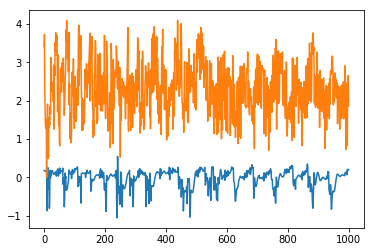

In [21]:
#plt.plot(sm.timestamp, sm.EMG)
plt.plot(sm.EMG)
#plt.show()
plt.plot(sm.Ydiff[np.isfinite(sm.Ydiff)] - np.min(sm.Ydiff))

In [22]:
np.min(sm.Ydiff)

70.97780399999999

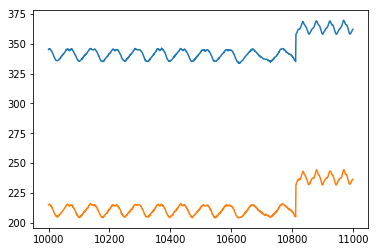

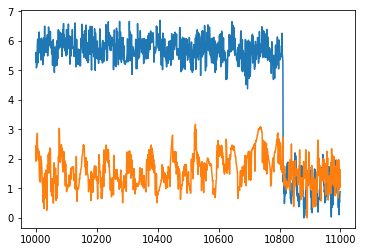

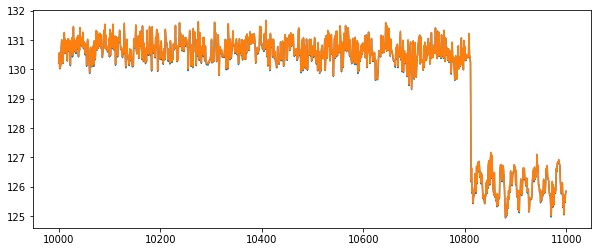

In [23]:
testFR = frame.iloc[10000:11000, :].copy()
testFR.loc[:,"Ydiff"] = pd.Series((testFR.pt1_cam1_Y - testFR.pt2_cam1_Y),  index = testFR.index)
testFR.loc[:,"Xdiff"] = pd.Series((testFR.pt1_cam1_X - testFR.pt2_cam1_X), index = testFR.index)
testFR.loc[:, "DistBwPts"] = np.sqrt((testFR.pt1_cam1_X - testFR.pt2_cam1_X)**2+ (testFR.pt1_cam1_Y - testFR.pt2_cam1_Y)**2 )



plt.plot(testFR.pt1_cam1_Y)
plt.plot(testFR.pt2_cam1_Y)
plt.show()
plt.plot(testFR.Ydiff - np.min(testFR.Ydiff))
plt.plot(testFR.Xdiff - np.min(testFR.Xdiff))
plt.show()
plt.figure(figsize = [10, 4])
plt.plot(testFR.Ydiff)
plt.plot(testFR.DistBwPts)

___
# practice with made-up data
# tutorial here: https://www.youtube.com/watch?v=2np77NOdnwk
___

In [268]:
timesteps = np.arange(0, 50.01, 0.01 )
trainX = np.sin(2*np.pi*timesteps) + np.random.normal(size=len(timesteps))*0.1
trainY =  np.cos(2*np.pi*timesteps) * ((np.cos(2*np.pi*timesteps)) > 0.999)*1 + np.random.normal(size=len(timesteps))*0.1

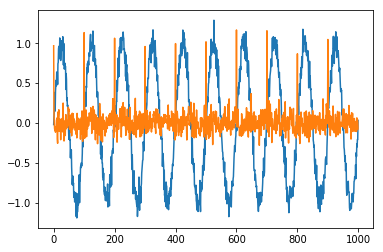

In [272]:
plt.plot(trainX[0:1000])
plt.plot(trainY[0:1000])



In [317]:
# reshape data
def reshape_data2(sequence, ysequence, seq_len):
    sequence_length = seq_len + 1
    result = []
    for index in range(len(sequence) - sequence_length):
        result.append(sequence[index: index + sequence_length])
    result = np.array(result)
    
    result2 = []
    for index in range(len(ysequence) - sequence_length):
        result2.append(ysequence[index: index + sequence_length])
    result2 = np.array(result2)
    
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    train2 = result2[:int(row), :]
    # shuffle windows
    #shuffInt = np.random.choice(np.arange(0, train.shape[1]), replace=False, size=train.shape[1])
#     train = train[:, shuffInt]
#     train2 = train2[:, shuffInt]
    #np.random.shuffle(train)
    
    x_train = train2[:, :-1]
    y_train = train[:, -1]
    x_test = result2[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    
    
    return [x_train, y_train, x_test, y_test]

In [318]:
x_train, y_train, x_test, y_test = reshape_data2(trainX, trainY, 200)
x_train.shape

(4320, 200, 1)

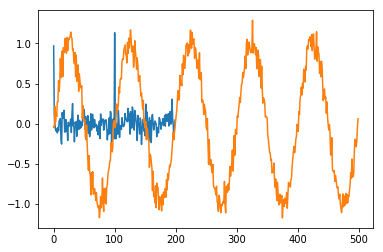

In [319]:
plt.plot(x_train[0, :])
plt.plot(y_train[0:500])

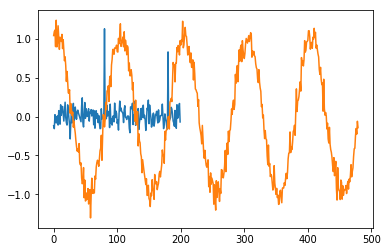

In [320]:
plt.plot(x_test[0, :])
plt.plot(y_test[0:500])

In [404]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.callbacks import EarlyStopping

In [491]:
def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_shape=(None, layers[0]),
        units=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(units = layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="adam", metrics = ['mse'])
    print("> Compilation Time : ", time.time() - start)
    return model

In [492]:
model= build_model([1,50,100,1])
earlystop = EarlyStopping(monitor='val_mean_squared_error', min_delta=0.0001, patience=10, verbose=1, mode='auto')

> Compilation Time :  0.012966632843017578


In [493]:
model_info = model.fit(x_train, y_train, batch_size = 512, epochs=100, validation_split=0.05, callbacks = [earlystop])

Train on 4104 samples, validate on 216 samples
Epoch 1/100
4104/4104 [==============================] - 6s 1ms/step - loss: 0.5090 - mean_squared_error: 0.5090 - val_loss: 0.5156 - val_mean_squared_error: 0.5156
Epoch 2/100
4104/4104 [==============================] - 3s 821us/step - loss: 0.4820 - mean_squared_error: 0.4820 - val_loss: 0.4593 - val_mean_squared_error: 0.4593
Epoch 3/100
4104/4104 [==============================] - 3s 829us/step - loss: 0.4328 - mean_squared_error: 0.4328 - val_loss: 0.4608 - val_mean_squared_error: 0.4608
Epoch 4/100
4104/4104 [==============================] - 4s 856us/step - loss: 0.4182 - mean_squared_error: 0.4182 - val_loss: 0.3817 - val_mean_squared_error: 0.3817
Epoch 5/100
4104/4104 [==============================] - 3s 832us/step - loss: 0.3819 - mean_squared_error: 0.3819 - val_loss: 0.3660 - val_mean_squared_error: 0.3660
Epoch 6/100
4104/4104 [==============================] - 3s 821us/step - loss: 0.3166 - mean_squared_error: 0.3166 - val

In [494]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,1,figsize=(10,5))
    # summarize history for accuracy
    axs.plot(range(1,len(model_history.history['mean_squared_error'])+1),model_history.history['mean_squared_error'])
    axs.plot(range(1,len(model_history.history['val_mean_squared_error'])+1),model_history.history['val_mean_squared_error'])
    axs.set_title('Model MSE')
    axs.set_ylabel('mean_squared_error')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(1,len(model_history.history['val_mean_squared_error'])+1),len(model_history.history['val_mean_squared_error'])/10)
    axs.legend(['train', 'val'], loc='best')
    plt.show()

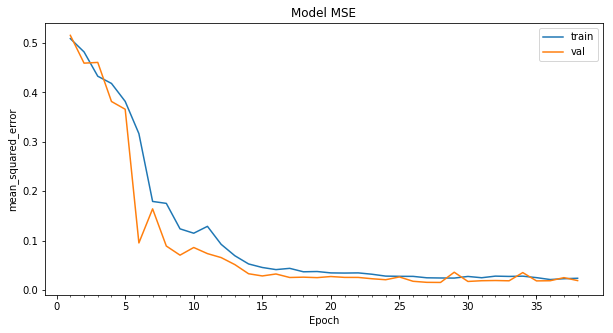

In [495]:
plot_model_history(model_info)

In [485]:
def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

In [496]:
predicted = predict_point_by_point(model, x_test)

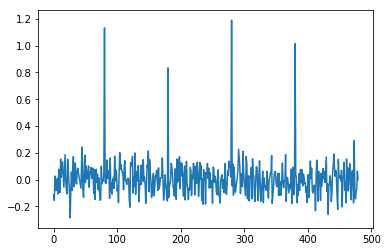

In [497]:
x_test.shape
plt.plot(x_test[:, 0, 0])

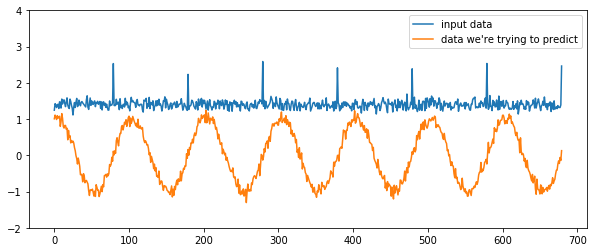

In [498]:
# here's what we're trying to predict
plt.figure(figsize = (10,4))
#plt.plot(x_test[:, 1, 0])
plt.plot(trainY[-680:] + 1.4, label = "input data") # why 680? refref
plt.plot(trainX[-680:], label = "data we're trying to predict")
plt.ylim([-2, 4])
plt.legend()

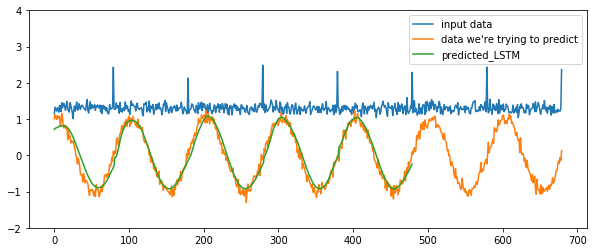

In [499]:
plt.figure(figsize = (10,4))
plt.plot(trainY[-680:] + 1.3, label = "input data")
plt.plot(trainX[-680:], label = "data we're trying to predict")
plt.ylim([-2, 4])
plt.plot(predicted, label = 'predicted_LSTM')
plt.legend()
#plt.plot(y_test)
plt.savefig(os.path.join(figDir, "LSTM_MadeUpData.png"), dpi = 500)


In [400]:
figDir

'D:\\Dropbox\\dataAnalysisForOthers\\MothMuscleLength\\Figures'

In [116]:
results = reshape_data(trainX, 50)

In [121]:
np.random.shuffle(results)
results.shape

shuffInt = np.random.choice(np.arange(0, results.shape[1]), replace=False, size=results.shape[1])
results[:, shuffInt]

array([[ 9.04827052e-01,  1.00000000e+00, -8.09016994e-01, ...,
         9.51056516e-01,  4.81753674e-01,  3.68124553e-01],
       [ 9.51056516e-01,  9.92114701e-01, -7.28968627e-01, ...,
         9.82287251e-01,  5.87785252e-01,  4.81753674e-01],
       [ 9.04827052e-01,  1.00000000e+00, -8.09016994e-01, ...,
         9.51056516e-01,  4.81753674e-01,  3.68124553e-01],
       ...,
       [-8.76306680e-01, -5.87785252e-01,  2.94162824e-15, ...,
        -8.09016994e-01, -9.92114701e-01, -9.68583161e-01],
       [-9.51056516e-01, -7.28968627e-01,  1.87381315e-01, ...,
        -9.04827052e-01, -9.51056516e-01, -9.04827052e-01],
       [ 3.09016994e-01, -1.25333234e-01,  6.84547106e-01, ...,
         1.87381315e-01,  8.09016994e-01,  8.76306680e-01]])

In [ ]:
shuffInt = np.random.choice(np.arange(0, result.shape[0]), replace=False, size=result.shape[0])
    train = train[:, shuffInt]